# Finite-element mode solver

You can mesh any component cross-section and solve the PDEs thanks to [femwell](https://helgegehring.github.io/femwell) mode - solver.

Unlike other mode solvers, this actually uses the component geometry instead of a hardcoded geometry.

You can directly compute the modes of a Gdsfactory cross-section (internally, it defines a "uz" mesh  perpendicular to a straight component with the provided cross-section).

You can also downsample layers from the LayerStack, and modify both the cross-section and LayerStack  prior to simulation to change the geometry. You can also define refractive indices on the active PDK.

In [1]:
try:
    import google.colab

    is_running_on_colab = True
    !pip install gdsfactory gplugins[femwell] > /dev/null
    !apt install python3-gmsh gmsh > /dev/null

except ImportError:
    is_running_on_colab = False

In [2]:
import matplotlib.pyplot as plt
import gdsfactory as gf
from tqdm.auto import tqdm
import numpy as np

from gdsfactory.technology import LayerStack
from gdsfactory.cross_section import rib
from gdsfactory.generic_tech import LAYER_STACK

from skfem.io.meshio import from_meshio

from femwell.maxwell.waveguide import compute_modes
from femwell.visualization import plot_domains

import sys
import logging
from rich.logging import RichHandler
import gdsfactory as gf
from gdsfactory.generic_tech import get_generic_pdk

from gplugins.gmsh import get_mesh

from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import shapely
import shapely.affinity
from scipy.constants import epsilon_0, speed_of_light
from shapely.ops import clip_by_rect
from skfem import Basis, ElementTriP0
from skfem.io.meshio import from_meshio

from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict
from femwell.visualization import plot_domains

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

logger = logging.getLogger()
logger.removeHandler(sys.stderr)
logging.basicConfig(level="WARNING", datefmt="[%X]", handlers=[RichHandler()])

First we choose a component to simulate. Here, a straight strip waveguide:

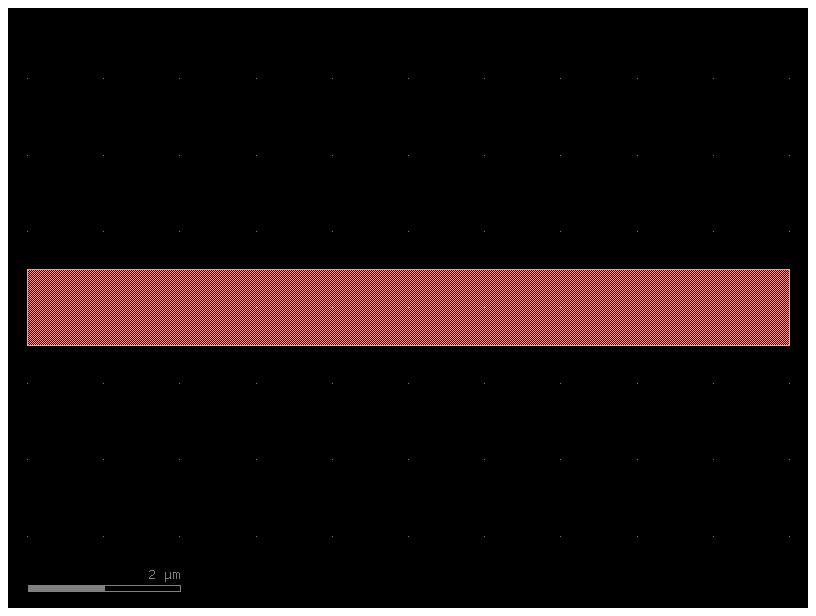

In [3]:
xs = gf.cross_section.strip(width=1)

c = gf.components.straight(cross_section=xs)
c

Then we choose a Layer Stack. Here, we simply downsample the generic stack:

In [4]:
filtered_layer_stack = LayerStack(
    layers={
        k: LAYER_STACK.layers[k]
        for k in (
            "core",
            "clad",
            "slab90",
            "box",
        )
    }
)

We can also change some of the values:

In [5]:
filtered_layer_stack.layers["core"].thickness = (
    0.22  # Perturb the layer_stack before simulating
)

filtered_layer_stack.layers["slab90"].thickness = (
    0.09  # Perturb the layer_stack before simulating
)

# When selecting resolutions, the names must match the keys of the layerstack
# Here, choose a finer mesh inside and close to the core
resolutions = {
    "core": {"resolution": 0.02, "DistMax": 2, "SizeMax": 0.2},
}

Using gplugins, we quickly generate a cross-sectional mesh:

In [6]:
mesh_gmsh = get_mesh(
    component=c,
    layer_stack=filtered_layer_stack,
    type="uz",  # we want a cross-section
    xsection_bounds=((1, -3), (1, 3)),  # the line from which we take a cross-section
    wafer_padding=3,  # pad simulation domain 3 microns around the component
    filename="mesh.msh",
    resolutions=resolutions,
    default_characteristic_length=0.5,
)

  0%|          | 0/3 [00:00<?, ?it/s]

We can now throw this mesh into FEMWELL directly:

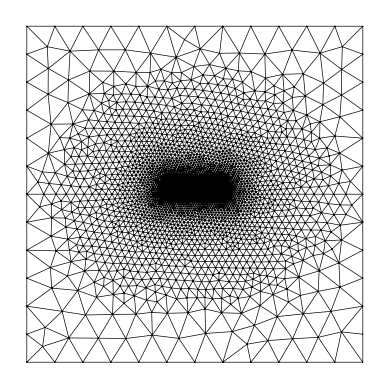

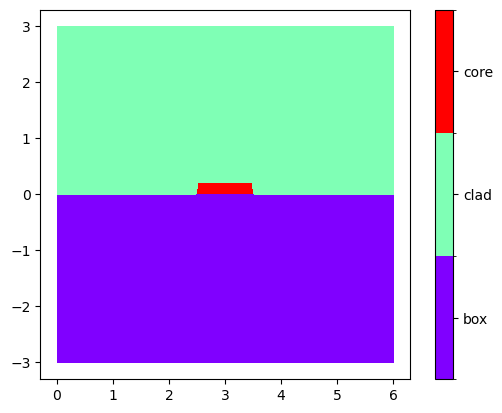

In [7]:
mesh = from_meshio(mesh_gmsh)
mesh.draw().show()

plot_domains(mesh)
plt.show()

Assign material values

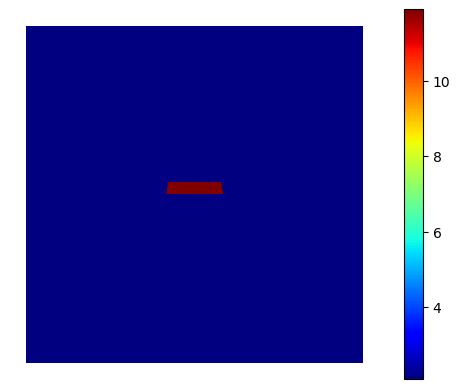

In [8]:
basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()
for subdomain, n in {"core": 3.45, "box": 1.444, "clad": 1.444}.items():
    epsilon[basis0.get_dofs(elements=subdomain)] = n**2
basis0.plot(epsilon, colorbar=True).show()

Solve for the modes:

In [9]:
wavelength = 1.55
modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=2, order=1)

You can use them as inputs to other [femwell mode solver functions](https://github.com/HelgeGehring/femwell/blob/main/femwell/mode_solver.py) to inspect or analyze the modes:

In [10]:
print(modes[0].te_fraction)

0.9978513183227828


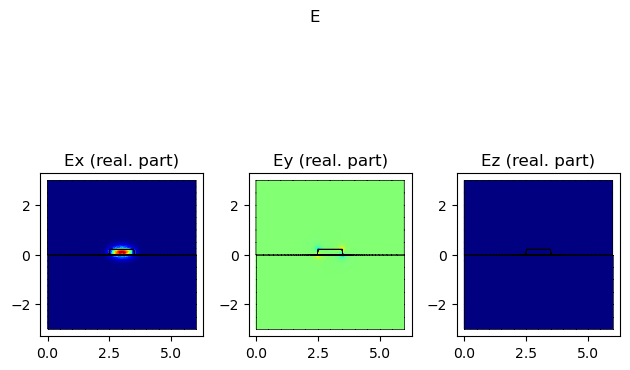

In [11]:
modes[0].show("E", part="real")

In [12]:
dir(modes[0])


[
    'E',
    'H',
    'Sx',
    'Sy',
    'Sz',
    '__annotations__',
    '__class__',
    '__dataclass_fields__',
    '__dataclass_params__',
    '__delattr__',
    '__dict__',
    '__dir__',
    '__doc__',
    '__eq__',
    '__format__',
    '__ge__',
    '__getattribute__',
    '__gt__',
    '__hash__',
    '__init__',
    '__init_subclass__',
    '__le__',
    '__lt__',
    '__match_args__',
    '__module__',
    '__ne__',
    '__new__',
    '__reduce__',
    '__reduce_ex__',
    '__repr__',
    '__setattr__',
    '__sizeof__',
    '__str__',
    '__subclasshook__',
    '__weakref__',
    'basis',
    'basis_epsilon_r',
    'calculate_confinement_factor',
    'calculate_coupling_coefficient',
    'calculate_effective_area',
    'calculate_intensity',
    'calculate_overlap',
    'calculate_pertubated_neff',
    'calculate_power',
    'calculate_propagation_loss',
    'epsilon_r',
    'frequency',
    'k',
    'k0',
    'n_eff',
    'omega',
    'plot',
    'plot_component',
   

In [13]:
modes[0].plot_component?

<Axes: title={'center': 'Ex (real. part)'}>

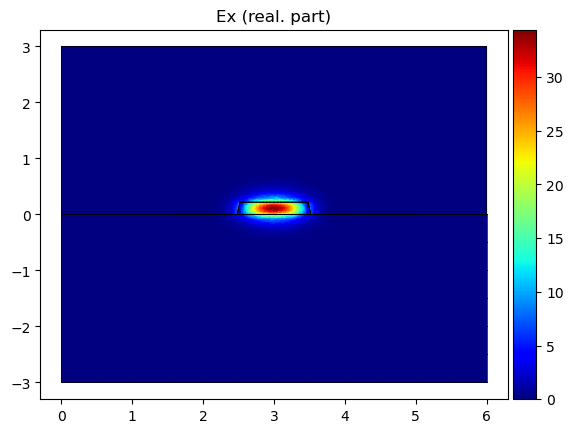

In [14]:
modes[0].plot_component("E", component="x", part="real", colorbar=True)

<Axes: title={'center': 'Ex (real. part)'}>

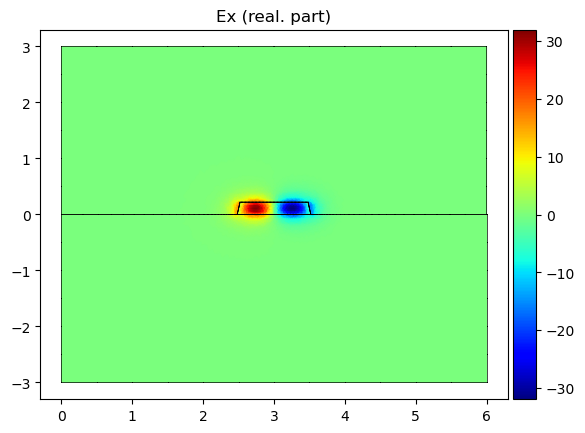

In [15]:
modes[1].plot_component("E", component="x", part="real", colorbar=True)

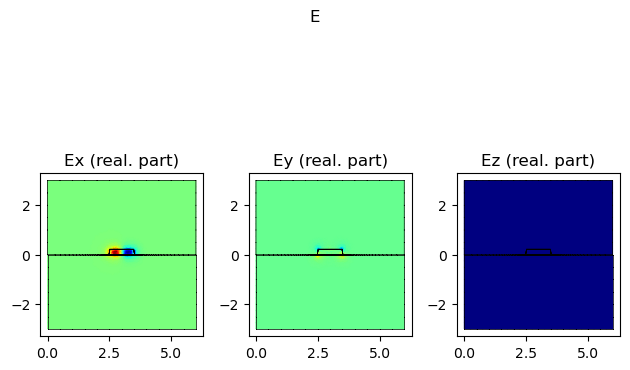

In [16]:
modes[1].show("E", part="real")